## Comparing different clustering algorithms on toy datasets

In [1]:
# Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
# Downloaded 9 June 2021 and modified to fit our needs.

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
# Imports
import time
import warnings
from os.path import join
from os import makedirs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn_extra import cluster as cluster_extra
from hdbscan import HDBSCAN
from gudhi.clustering.tomato import Tomato
from itertools import cycle, islice

rng_seed = 399
np.random.seed(rng_seed)

<IPython.core.display.Javascript object>

In [4]:
# Prepare output dirs
output_plots_dir = "output_plots"
makedirs(output_plots_dir, exist_ok=True)

<IPython.core.display.Javascript object>

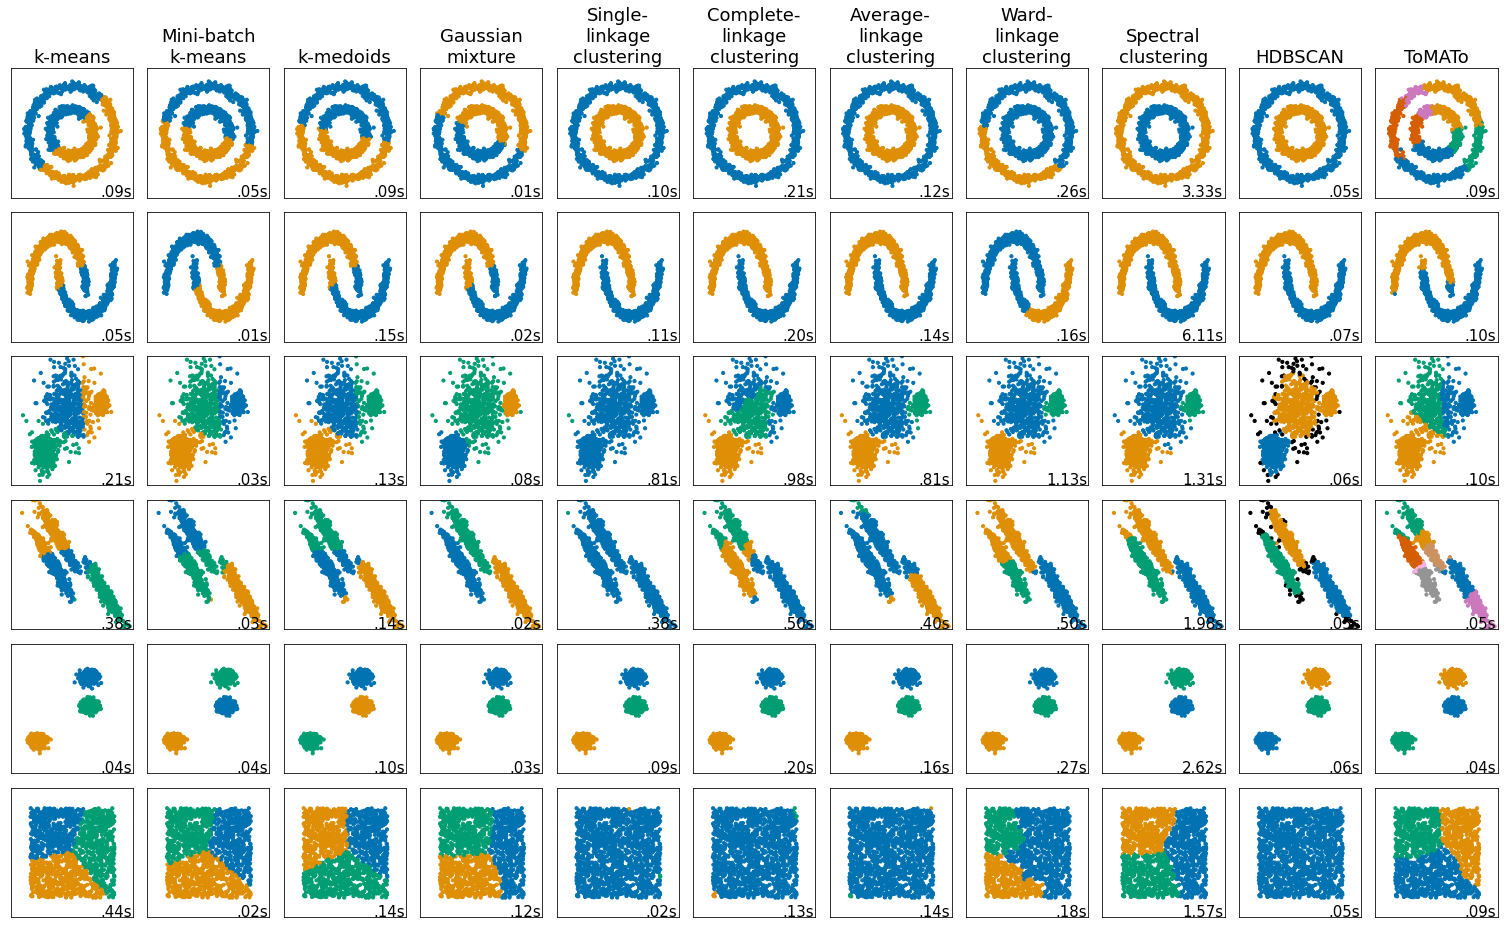

<IPython.core.display.Javascript object>

In [5]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 10,
    "tomato_neighbours": 75,
    "allow_single_cluster": False,
}

datasets_and_params = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 20,
            "xi": 0.25,
            "tomato_neighbours": 150,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "tomato_neighbours": 150,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 5,
            "xi": 0.035,
            "min_cluster_size": 10,
            "tomato_neighbours": 150,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 20,
            "xi": 0.1,
            "min_cluster_size": 10,
        },
    ),
    (blobs, {}),
    (
        no_structure,
        {
            "min_cluster_size": 500,
            "min_samples": 1,
            "tomato_neighbours": 150,
            "allow_single_cluster": True,
        },
    ),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets_and_params):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    k_means = cluster.KMeans(n_clusters=params["n_clusters"], random_state=rng_seed)
    mb_k_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"], random_state=rng_seed
    )
    k_medoids = cluster_extra.KMedoids(
        n_clusters=params["n_clusters"], random_state=rng_seed
    )
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=rng_seed,
    )
    agglo_single = cluster.AgglomerativeClustering(
        linkage="single",
        n_clusters=params["n_clusters"],
        affinity="euclidean",
        connectivity=connectivity,
    )
    agglo_complete = cluster.AgglomerativeClustering(
        linkage="complete",
        n_clusters=params["n_clusters"],
        affinity="euclidean",
        connectivity=connectivity,
    )
    agglo_average = cluster.AgglomerativeClustering(
        linkage="average",
        n_clusters=params["n_clusters"],
        affinity="cityblock",
        connectivity=connectivity,
    )
    agglo_ward = cluster.AgglomerativeClustering(
        linkage="ward",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    hdbscan = HDBSCAN(
        min_cluster_size=params["min_cluster_size"],
        min_samples=params["min_samples"],
        cluster_selection_epsilon=params["eps"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    tomato = Tomato(
        k=params["tomato_neighbours"], graph_type="knn", density_type="logDTM"
    )

    clustering_algorithms = (
        ("k-means", k_means),
        ("Mini-batch\nk-means", mb_k_means),
        ("k-medoids", k_medoids),
        ("Gaussian\nmixture", gmm),
        ("Single-\nlinkage\nclustering", agglo_single),
        ("Complete-\nlinkage\nclustering", agglo_complete),
        ("Average-\nlinkage\nclustering", agglo_average),
        ("Ward-\nlinkage\nclustering", agglo_ward),
        ("Spectral\nclustering", spectral),
        ("HDBSCAN", hdbscan),
        ("ToMATo", tomato),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets_and_params), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(sns.color_palette(palette="colorblind", as_cmap=True)),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.tight_layout()
plt.savefig(
    join(output_plots_dir, "cluster_algorithms_comparison.png"),
    bbox_inches="tight",
)